# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import time


% matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 1. Data Exploration / Prepocessing

In order to understand the datasets and uncover initial patterns, characteristics, and points of interest, first we need to explore the datasets which includes checking the missing value, visualizing the data distribution, etc. In that way, we could see what the data can tell us and how to select the important features to support the model implementation.  
And also we will do some preprocessing, that step in which the data gets transformed, or Encoded, to bring it to such a state that now the machine can easily parse it.

### 1.1 portfolio data

In [3]:
# Show portfolio dataset
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
# Shape of dataset
portfolio.shape

(10, 6)

In [5]:
# Calculate null values in portfolio dataframe
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

As shown above, there are no null values in portfolio dataframe.

In [6]:
# the number of unique offers in dataset
portfolio['id'].nunique()

10

we notice that the number of unique offers is 10, the same as the number of rows, which mean there is no duplicates ids

In [7]:
# the number of unique offer types in dataset
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [8]:
# count the number of offer by offer type
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

In [9]:
def clean_portfolio(portfolio):
    
    '''
    data cleaning the portfolio dataframe
    
    INPUT:
    portfolio - the portfolio dataframe to be cleaned
    
    OUTPUT:
    portfolio - the cleaned portfolio dataframe
    
    '''
    
    # Change name of feature id to offer_id
    portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

    # change the duration from day to hour
    clean_portfolio = portfolio.copy()
    clean_portfolio['duration'] = clean_portfolio['duration'] * 24
    
    # apply one hot encoding to channels culumn
    
    channels=clean_portfolio['channels'].map(lambda x: ','.join(map(str, x))).str.get_dummies(sep=',')
    
    
    # apply one hot encoding to offer_type column
    offer_type = pd.get_dummies(clean_portfolio['offer_type'])
    
    # drop the culumns channels and offer_type 
    clean_portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)
    
    # combine the dataframe clean_portfolio and offer_type to form a cleaned dataframe
    clean_portfolio = pd.concat([clean_portfolio, channels, offer_type], axis=1, sort=False)
    
    return clean_portfolio


In [10]:
clean_portfolio=clean_portfolio(portfolio)

In [11]:
clean_portfolio.head()

,difficulty,duration,offer_id,reward,email,mobile,social,web,bogo,discount,informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,1,0,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,0,1,0,1,0


### 1.2 profile data

In [12]:
# Show profile dataset
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [13]:
# Shape of dataset
profile.shape

(17000, 5)

In [14]:
# Calculate null values in profile dataframe
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

From above, we can observe that gender and income features each have 2175 null values

In [15]:
# the number of unique profiles in dataset
profile.id.nunique()

17000

In [16]:
import matplotlib.pyplot as plt

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

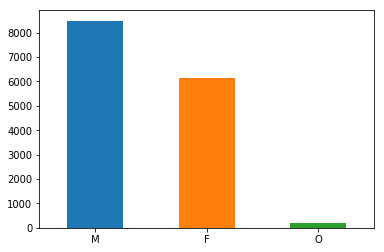

In [17]:
(profile['gender'].value_counts()).plot(kind='bar')
plt.xticks(rotation=0)

We can see that there are more males members than female members.

In [18]:
# Calculate count of unique age
profile['age'].value_counts().sort_index(ascending=False)

118    2175
101       5
100      12
99        5
98        5
97       13
96        8
95       22
94       33
93       29
92       40
91       47
90       52
89       53
88       64
87       66
86       54
85       70
84       83
83      102
82      105
81      118
80      116
79      117
78      135
77      141
76      155
75      159
74      193
73      209
       ... 
47      232
46      212
45      231
44      192
43      215
42      227
41      189
40      202
39      182
38      172
37      197
36      175
35      118
34      147
33      152
32      139
31      113
30      131
29      129
28      137
27      139
26      157
25      136
24      139
23      126
22      131
21      140
20      135
19      135
18       70
Name: age, Length: 85, dtype: int64

From above, we can observe that there are 2175 observations with age 118 which is also the maximum age. The number of observations for this age is way too much than the number of observations for second highest age 101 which is only 5 which indicates that there are more people with age 118 than with age 101 which seems unrealistic. Also, the number of observations with age 118 i.e. 2175 is equal to the number of missing values in features gender and income. Let us analyse the profile data for age 118 more.

In [19]:
# View records of profile dataframe for age 118
profile_118 = profile[profile['age'] == 118]
profile_118.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN
10,118,20170824,None,c4863c7985cf408faee930f111475da3,NaN
11,118,20150919,None,148adfcaa27d485b82f323aaaad036bd,NaN
17,118,20170801,None,744d603ef08c4f33af5a61c8c7628d1c,NaN
23,118,20170907,None,2b826eba31074a059d63b0ae8f50b7d5,NaN


In [20]:
# Show number of profiles with the age 118
profile_118.shape[0]

2175

In [21]:
# Show number of null values of the column gender when age=118
profile_118['gender'].isnull().sum()

2175

In [22]:
# Show number of null values of the column income when age=118
profile_118['income'].isnull().sum()

2175

By viewing those results above, we can observe that all profiles with age 118, have missing values in gender column and income column too.

Text(0.5,1,'Distribution of age counts')

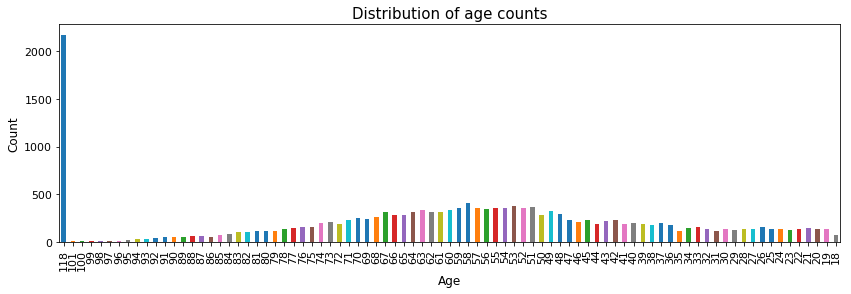

In [23]:
# Plot distribution of ages in profile dataframe 
profile['age'].value_counts().sort_index(ascending=False).plot.bar(figsize=(14,4), fontsize=11);
plt.xlabel('Age', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of age counts', fontsize=15)


From above, we can cleary see that customers with age 118 stand out in distribution plot, which seems outlier. and I checked that for all profiles that have age equal to 118, they do not have any gender and income, also the number of customers with age 118 which is 2175 is unrealistic, For those reasons I will drop all columns that have age 118.

In [24]:
def clean_profile(profile):
    
    """ Transforms a DataFrame that contains demographic data for each 
    customer
    
    INPUT:
        (Optional) data_dir: String that stores the full path to the
                             data directory
    
    OUTPUT:
        profile: DataFrame that contains demographic data for each 
                 customer
    """
    # copy dataframe from profile to clean_profile
    clean_profile = profile.copy()
    
    # Change name of culumn id to customer_id in profile dataframe
    clean_profile.rename(columns={'id': 'customer_id'}, inplace=True)
    
    # Remove customers with age 118
    profile_118 = clean_profile[clean_profile['age'] == 118]
    clean_profile.drop(index=profile_118.index, inplace=True) 
    
    # OneHotEncoding feature 'gender'
    gender_dummies = pd.get_dummies(clean_profile['gender'], prefix='', prefix_sep='')
    
    
    # Convert fetaure 'age' into 'age_by_decade' which would be helpful in determining if a particular age 
    #is influenced more by an offer
    clean_profile['age_by_decade'] = pd.cut(clean_profile['age'], bins=range(10,120,10),right=False, labels=['10s','20s', '30s', '40s', '50s','60s', '70s', '80s', '90s', '100s'])
         
    # OneHotEncoding feature 'age_by_decade'
    age_dummies = pd.get_dummies(clean_profile['age_by_decade'], prefix='age', prefix_sep='_')
    
    # Drop feature 'age' 
    clean_profile.drop(columns=['age'], axis=1, inplace=True)
    
    
    # Convert type of feature 'became_member_on' to type Datetime
    type(pd.to_datetime(clean_profile['became_member_on'],format='%Y%m%d').dt) 
    

    # Create feature 'became_member_year' in which customer became member from feature 'became_member_on'
    clean_profile['became_member_year'] = pd.to_datetime(clean_profile['became_member_on'],format='%Y%m%d').dt.year

    # Create feature 'became_member_month' in which customer became member from feature 'became_member_on'
    clean_profile['became_member_month'] = pd.to_datetime(clean_profile['became_member_on'],format='%Y%m%d').dt.month
    
    # Create feature 'became_member_day' in which customer became member from feature 'became_member_on'
    clean_profile['became_member_day'] = pd.to_datetime(clean_profile['became_member_on'],format='%Y%m%d').dt.day
    
    # Create feature 'became_member_tenure' of customers from feature 'became_member_on'
    clean_profile['became_member_tenure'] = (datetime.today().date() - pd.to_datetime(clean_profile['became_member_on'],format='%Y%m%d').dt.date).dt.days

    # Drop feature 'became_member_on'
    clean_profile.drop(columns=['became_member_on'], axis=1, inplace=True)
    
    # OneHotEncoding feature 'became_member_year'
    year_dummies = pd.get_dummies(clean_profile['became_member_year'], prefix='', prefix_sep='')

    # OneHotEncoding feature 'became_member_month'
    month_dummies = pd.get_dummies(clean_profile['became_member_month'], prefix='month', prefix_sep='_')
    
    # Convert feature 'income' into 'income_by_range' which would be helpful in determining
    # if a particular income range is influenced more by an offer
    clean_profile['income_by_range'] = pd.cut(clean_profile['income'], bins=range(30000,140000,10000), right=False,\
                                    labels=['30ths','40ths', '50ths', '60ths', '70ths','80ths', '90ths',\
                                            '100ths', '110ths', '120ths'])
    
    # OneHotEncoding feature 'income_by_range'
    income_dummies = pd.get_dummies(clean_profile['income_by_range'], prefix='income', prefix_sep='_')
    
    # combine the dataframe clean_profile with the different dummies variables
    clean_profile = pd.concat([clean_profile, gender_dummies, age_dummies,year_dummies,month_dummies,income_dummies], axis=1, sort=False)
    

    # Return a DataFrame with clean customer profile data
    return clean_profile

In [25]:
# apply the function clean_profile on our dataset 'profile' to  get a cleaned profile
clean_profile=clean_profile(profile)

In [26]:
# show the cleaned profile data
clean_profile.head()

,gender,customer_id,income,age_by_decade,became_member_year,became_member_month,became_member_day,became_member_tenure,income_by_range,F,...,income_30ths,income_40ths,income_50ths,income_60ths,income_70ths,income_80ths,income_90ths,income_100ths,income_110ths,income_120ths
1,F,0610b486422d4921ae7d2bf64640c50b,112000.0,50s,2017,7,15,1028,110ths,1,...,0,0,0,0,0,0,0,0,1,0
3,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,70s,2017,5,9,1095,100ths,1,...,0,0,0,0,0,0,0,1,0,0
5,M,e2127556f4f64592b11af22de27a7932,70000.0,60s,2018,4,26,743,70ths,0,...,0,0,0,0,1,0,0,0,0,0
8,M,389bc3fa690240e798340f5a15918d5c,53000.0,60s,2018,2,9,819,50ths,0,...,0,0,1,0,0,0,0,0,0,0
12,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,50s,2017,11,11,909,50ths,0,...,0,0,1,0,0,0,0,0,0,0


In [27]:
# show the columns of cleaned profile data
clean_profile.columns

Index(['gender', 'customer_id', 'income', 'age_by_decade',
       'became_member_year', 'became_member_month', 'became_member_day',
       'became_member_tenure', 'income_by_range', 'F', 'M', 'O', 'age_10s',
       'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s',
       'age_80s', 'age_90s', 'age_100s', '2013', '2014', '2015', '2016',
       '2017', '2018', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'income_30ths', 'income_40ths', 'income_50ths',
       'income_60ths', 'income_70ths', 'income_80ths', 'income_90ths',
       'income_100ths', 'income_110ths', 'income_120ths'],
      dtype='object')

In [28]:
def plot_bar(data,column,xlabel,ylabel,title):
    
    """ function plots a bar chart
    
    INPUT:
        data : string that stores dataframe name
        column : string that stores the culumn name
        xlabel : string that stores xlabel
        ylabel : string that stores ylabel
        title : string that stores the title of the plot
    
    """
    data[column].value_counts().plot.bar(figsize=(20,6), fontsize=12,color='c')
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.title(title, fontsize=18)

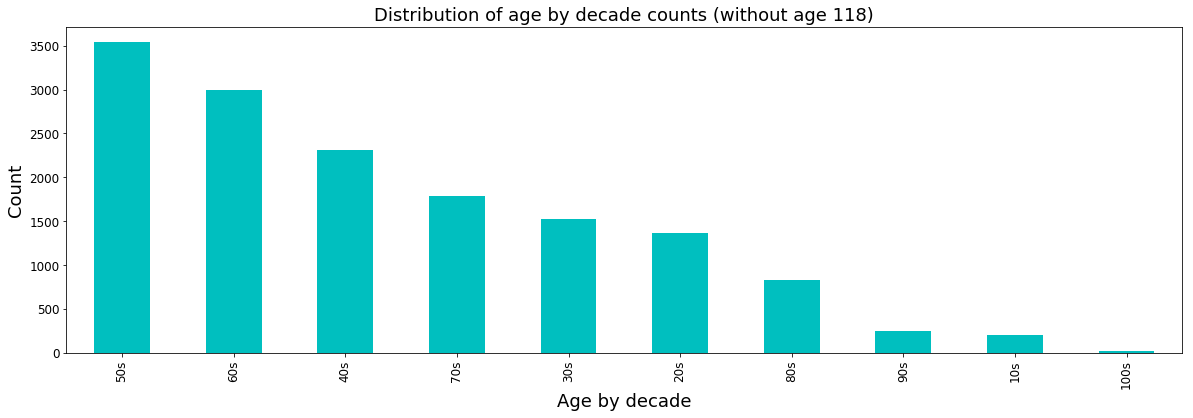

In [29]:
# Plot distribution of ages in profile dataframe after observations with age 118 has been dropped 
plot_bar(clean_profile,'age_by_decade','Age by decade','Count','Distribution of age by decade counts (without age 118)')


The plot shows that the feature age after dropping age 118 is uniformly distributed, we see that the age of the majority f our costumers is between 40 and 80 years old .

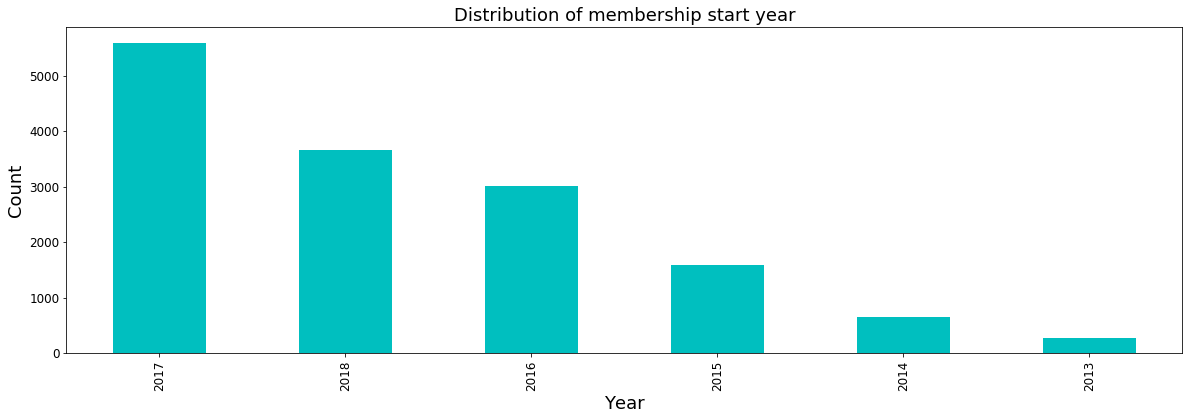

In [30]:
# Plot distribution of customer count per year in which the customer became member 
plot_bar(clean_profile,'became_member_year','Year','Count','Distribution of membership start year')


The results suggest that most customers joined the Starbucks rewards program in 2017 followed by 2018.

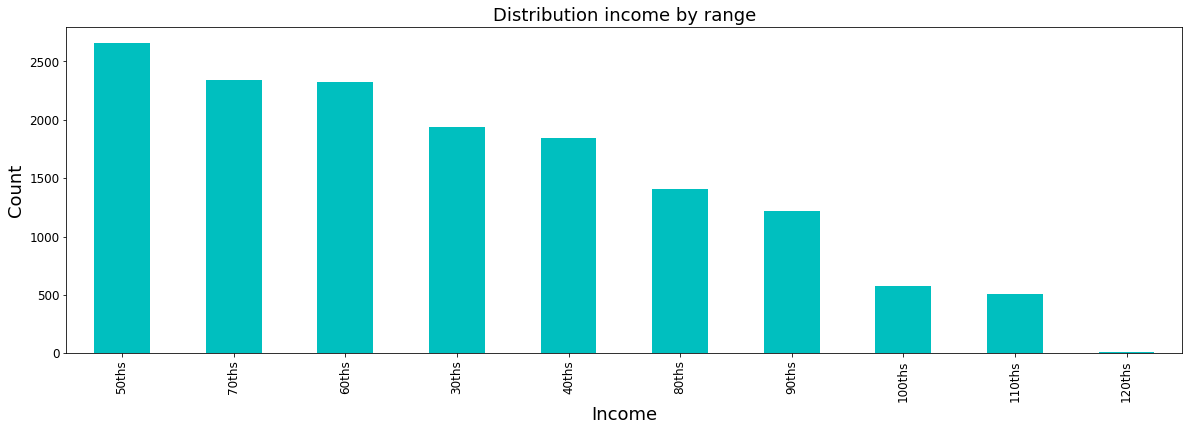

In [31]:
# Plot distribution of customer count per year in which the customer became member 
plot_bar(clean_profile,'income_by_range','Income','Count','Distribution income by range')


from the plot above, we see that most customers incomes are between 30 000 and 90 000

Text(0.5,1,'Gender counts by membership year')

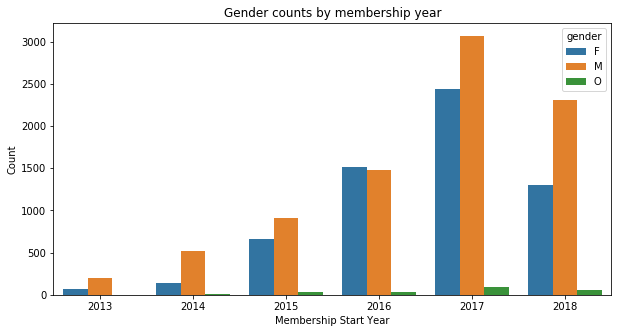

In [32]:
# groupby start_year and gender to plot a graph
membership_date = clean_profile.groupby(['became_member_year', 'gender']).size()
membership_date = membership_date.reset_index()
membership_date.columns = ['became_member_year', 'gender', 'count']

# plot a bar graph for age distribution as a function of gender in membership program
plt.figure(figsize=(10, 5))
sns.barplot(x='became_member_year', y='count', hue='gender', data=membership_date)
plt.xlabel('Membership Start Year')
plt.ylabel('Count');
plt.title('Gender counts by membership year')


The plot depict that there are more male customers joining the program every year than female customers.

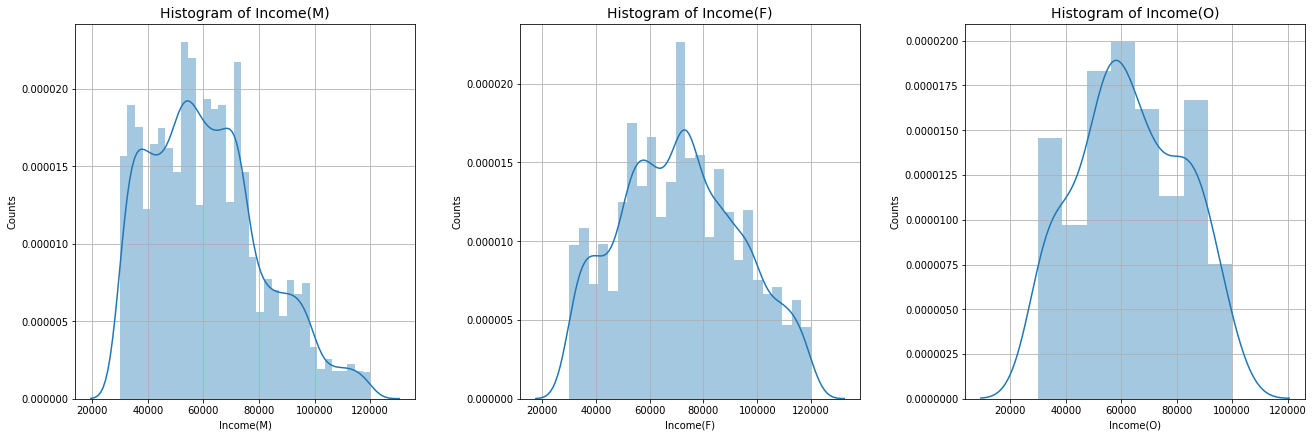

In [33]:
# Plot histograms of income per gender

# to be able to draw three subplots in a row
fig, ax = plt.subplots(figsize=(20,8),nrows=1, ncols=3, sharex=True, sharey=True)
fig.tight_layout(pad=9.0)

# plot a male customers income distribution
plt.subplot(131)
sns.distplot(clean_profile.loc[clean_profile['gender'] == 'M', 'income'])
plt.xlabel('Income(M)', fontsize=10)
plt.ylabel('Counts', fontsize=10)
plt.title('Histogram of Income(M)', fontsize=14)
plt.grid(True)

# plot a female customers income distribution
plt.subplot(132)
sns.distplot(clean_profile.loc[clean_profile['gender'] == 'F', 'income'])
plt.xlabel('Income(F)', fontsize=10)
plt.ylabel('Counts', fontsize=10)
plt.title('Histogram of Income(F)', fontsize=14)
plt.grid(True)

# plot other customers income distribution
plt.subplot(133)
sns.distplot(clean_profile.loc[clean_profile['gender'] == 'O', 'income'])
plt.xlabel('Income(O)', fontsize=10)
plt.ylabel('Counts', fontsize=10)
plt.title('Histogram of Income(O)', fontsize=14)
plt.grid(True)

plt.show()



from the plots above we conclude that minimum and maximum incomes for both male and female are approximately same but the count of male customers in low-income level is slightly higher than that of female customers. Also, income distribution for Others is also similar to males and females, with a minimum and maximum incomes less than males and females.

### 1.3 Transcript data

In [34]:
# show the head of dataframe transcript
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [35]:
# Print shape of transcript dataframe
transcript.shape

(306534, 4)

In [36]:
# Calculate null values in transaction dataframe
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

As shown above, there are no null values in transcript dataframe

In [37]:
# calculate number of observations in transcript of cunsomers having age 118
id_age_118 = profile_118['id'].unique().tolist()
transcript['person'].isin(id_age_118).value_counts()

False    272762
True      33772
Name: person, dtype: int64

in the section of cleaning profile dataset, I found that customers with age 118 are outliers, for that reason I droped all rows with age 118, I'll do the same here because we don't have any ids referring to costumers with age 118 in the profile dataset.

In [38]:
# Print features of transcript dataframe
transcript.columns

Index(['event', 'person', 'time', 'value'], dtype='object')

In [39]:
def clean_trascript(transcript):
    
    '''
    data cleaning the transcript dataframe
    
    INPUT:
    transcript - the transcript dataframe to be cleaned
    
    OUTPUT:
    transcript - the cleaned transcript dataframe
    
    '''
    # copy dataframe from transcript to clean_transcript
    clean_transcript = transcript.copy()
    
    # Change name of feature person to customer_id in transcript dataframe
    clean_transcript.rename(columns={'person': 'customer_id'}, inplace=True)
    
    # Remove observations having customers with age 118 from transcript dataframe
    clean_transcript = clean_transcript[~clean_transcript['customer_id'].isin(id_age_118)]    
    
    return clean_transcript


In [40]:
clean_transcript=clean_trascript(transcript)

In [41]:
clean_transcript.head()

,event,customer_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [42]:
# Check if customers with age 118 has been removed from clean_transcript dataframe
clean_transcript['customer_id'].isin(id_age_118).sum()

0

we observe that all customers with age 118 are successfuly droped 

In [43]:
# Check if all the customers in clean_profile dataframe are also in clean_transcript dataframe
len(set(clean_transcript['customer_id'].unique()) - set(clean_profile['customer_id'].unique()))

0

the above result shows that all the customers in clean_profile dataframe are also in clean_transcript dataframe

In [44]:
# the percentage of unique values in event feature
round((transcript['event'].value_counts()/transcript['event'].value_counts().sum())*100,2)

transaction        45.33
offer received     24.88
offer viewed       18.83
offer completed    10.95
Name: event, dtype: float64

From above, we can observe that there are 45.45% of events as transactions, 24.38% of events as offers received, 18.28% of events as offers viewed and 11.89 % of events as offers completed. We need to separate events with type 'transactions' and 'offers' to be used later on for analysis.

In [45]:
# Create dataframe offers_df containing only offers events and transaction_df containing only transaction event
# Create a list of offer event types
offer_event_list = ['offer received', 'offer viewed', 'offer completed']

# Find index where feature 'event' is 'offer received', 'offer viewed', 'offer completed'
offer_index = clean_transcript[clean_transcript['event'].isin(offer_event_list)].index

# Find index where feature event is 'transaction'
transaction_index = clean_transcript[~clean_transcript['event'].isin(offer_event_list)].index

# Create offers_df
offers_df = clean_transcript.loc[offer_index,:]

# Create transaction_df
transaction_df = clean_transcript.loc[transaction_index,:]

In [46]:
# show the dataframe offers_df
offers_df.head()

,event,customer_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [47]:
# show the dataframe offers_df
transaction_df.head()

,event,customer_id,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


In [48]:
# Print unique values in feature event in transaction_df
transaction_df['event'].unique()

array(['transaction'], dtype=object)

In [49]:
# Print unique values in feature event in offers_df
offers_df['event'].unique()

array(['offer received', 'offer viewed', 'offer completed'], dtype=object)

From above, we can observe that dataframe offers_df contains only events 'offer received', 'offer viewed' and 'offer completed' and dataframe transaction_df contains only event 'transaction'.

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

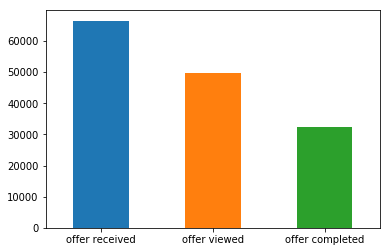

In [50]:
# plot value counts in feature offers_df
offers_df['event'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)

(array([0]), <a list of 1 Text xticklabel objects>)

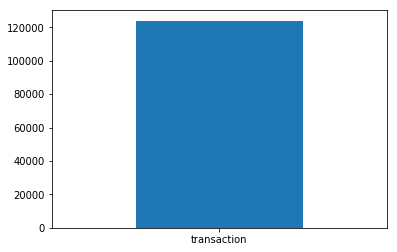

In [51]:
# plot value counts in feature offers_df
transaction_df['event'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)

In [52]:
# Create function to retrieve offer_id from feature value
def offer_id(x):
    for key,value in x.items():
        if key in ['offer id','offer_id']:
            return str(value)

In [53]:
# Create column 'offer_id' and applying the function offer_id
offers_df['offer_id'] = offers_df['value'].apply(offer_id)

In [54]:
offers_df.head()

,event,customer_id,time,value,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7


In [55]:
# Print unique offer_id in offers_df
offers_df['offer_id'].unique()

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '2906b810c7d4411798c6938adc9daaa5',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '3f207df678b143eea3cee63160fa8bed',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '5a8bc65990b245e5a138643cd4eb9837'], dtype=object)

In [56]:
# Create another column 'offer_type' with respect to feature 'offer_id'
offers_df['offer_type'] = offers_df['offer_id'].copy()



offers_df['offer_type'].replace(['ae264e3637204a6fb9bb56bc8210ddfd','4d5c57ea9a6940dd891ad53e9dbe8da0',\
                                 '9b98b8c7a33c4b65b9aebfe6a799e6d9','f19421c1d4aa40978ebb69ca19b0e20d'],\
                                 'bogo', inplace=True)

offers_df['offer_type'].replace(['0b1e1539f2cc45b7b9fa7c272da2e1d7','2298d6c36e964ae4a3e7e9706d1fb8c2',\
                                 'fafdcd668e3743c1bb461111dcafc2a4','2906b810c7d4411798c6938adc9daaa5'],\
                                 'discount', inplace=True)

offers_df['offer_type'].replace(['3f207df678b143eea3cee63160fa8bed','5a8bc65990b245e5a138643cd4eb9837'],\
                                 'informational', inplace=True)

In [57]:
offers_df.head()

,event,customer_id,time,value,offer_id,offer_type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,discount
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,bogo
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,informational
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,discount


In [58]:
# Drop feature value as it is not required now and drop feature offer_type as that information is also in portfolio dataframe
offers_df.drop(columns=['value', 'offer_type'], inplace=True)

# OneHotEncoding feature 'event'
offers_df = pd.get_dummies(offers_df, columns=['event'], prefix='', prefix_sep='')

# Reorder columns of offers_df dataframe
col_order = ['customer_id', 'offer_id', 'time', 'offer received', 'offer viewed', 'offer completed']
offers_df = offers_df.reindex(col_order, axis=1)

In [59]:
offers_df.head()

,customer_id,offer_id,time,offer received,offer viewed,offer completed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,1,0,0
5,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,3f207df678b143eea3cee63160fa8bed,0,1,0,0
8,aa4862eba776480b8bb9c68455b8c2e1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0


In [60]:
# Create column 'amount' in the dataframe transaction_df
transaction_df['amount'] = transaction_df['value'].apply(lambda x: x['amount'])

In [61]:
# Drop'event' and 'value' features
transaction_df.drop(columns=['event', 'value'], inplace=True)

In [62]:
transaction_df.head()

,customer_id,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


### 1.4 Combined data (clean_portfolip & clean_profile & offers_df & transaction_df)

In [127]:
# Create function to combine transaction, offer, portfolio and profile datasets
def create_combined_data(portfolio, profile, offers_df, transaction_df):
    
    
    '''Create a combined dataframe from the transaction, demographic and offer data:
    INPUT:
        portfolio - (dataframe),offer metadata
        profile - (dataframe),customer demographic data
        offers_df - (dataframe), offers data for customers
        transaction_df - (dataframe), transaction data for customers
    OUTPUT:
        combined_data_df - (dataframe),combined data from transaction, demographic and offer data
    '''
    
    combined_data = [] # Initialize empty list for combined data
    customer_id_list = offers_df['customer_id'].unique().tolist() # List of unique customers in offers_df
        

    # Iterate over each customer
    for i,cust_id in enumerate(customer_id_list):
            
        # select customer profile from profile data
        cust_profile = clean_profile[clean_profile['customer_id'] == cust_id] 
        
        # select offers associated with the customer from offers_df
        cust_offers_data = offers_df[offers_df['customer_id'] == cust_id]
        
        # select transactions associated with the customer from transactions_df
        cust_transaction_df = transaction_df[transaction_df['customer_id'] == cust_id]
        
        # select received, completed, viewed offer data from customer offers
        offer_received_data  = cust_offers_data[cust_offers_data['offer received'] == 1]
        offer_viewed_data = cust_offers_data[cust_offers_data['offer viewed'] == 1]
        offer_completed_data = cust_offers_data[cust_offers_data['offer completed'] == 1]
            
        # Iterate over each offer received by a customer
        rows = [] # Initialize empty list for a customer records
            
        for off_id in offer_received_data['offer_id'].values.tolist():
            
            # select duration of a particular offer_id
            duration = clean_portfolio.loc[clean_portfolio['offer_id'] == off_id, 'duration'].values[0]
            
            # select the time when offer was received
            off_recd_time = offer_received_data.loc[offer_received_data['offer_id'] == off_id, 'time'].values[0]
            
            # Calculate the time when the offer ends
            off_end_time = off_recd_time + duration
            
            #Initialize a boolean array that determines if the customer viewed an offer between offer period
            offers_viewed = np.logical_and(offer_viewed_data['time'] >= off_recd_time,offer_viewed_data['time'] <= off_end_time)
                
            # Check if the offer type is 'bogo' or 'discount'
            if (clean_portfolio[clean_portfolio['offer_id'] == off_id]['bogo'].values[0] == 1 or\
                    clean_portfolio[clean_portfolio['offer_id'] == off_id]['discount'].values[0] == 1):
                
                #Initialize a boolean array that determines if the customer completed an offer between offer period
                offers_comp = np.logical_and(offer_completed_data ['time'] >= off_recd_time,\
                                                 offer_completed_data ['time'] <= off_end_time)
                    
                #Initialize a boolean array that selects customer transctions between offer period
                cust_tran_within_period = cust_transaction_df[np.logical_and(cust_transaction_df['time'] >= off_recd_time,\
                                                                                 cust_transaction_df['time'] <= off_end_time)]
                    
                # Determine if the customer responded to an offer(bogo or discount) or not
                cust_response = np.logical_and(offers_viewed.sum() > 0, offers_comp.sum() > 0) and\
                                                    (cust_tran_within_period['amount'].sum() >=\
                                                     clean_portfolio[clean_portfolio['offer_id'] == off_id]['difficulty'].values[0])
                
            # Check if the offer type is 'informational'
            elif clean_portfolio[clean_portfolio['offer_id'] == off_id]['informational'].values[0] == 1:
                
                #Initialize a boolean array that determines if the customer made any transctions between offer period
                cust_info_tran = np.logical_and(cust_transaction_df['time'] >= off_recd_time,\
                                                    cust_transaction_df['time'] <= off_end_time)                   
                    
                # Determine if the customer responded to an offer(informational) or not
                cust_response = offers_viewed.sum() > 0 and cust_info_tran.sum() > 0                  
                
                #Initialize a boolean array that selects customer transctions between offer period
                cust_tran_within_period = cust_transaction_df[np.logical_and(cust_transaction_df['time'] >= off_recd_time,\
                                                                                 cust_transaction_df['time'] <= off_end_time)]
                
            # Initialize a dictionary for a customer with required information for a particular offer
            cust_rec = {'cust_response': int(cust_response),'time': off_recd_time,'total_amount': cust_tran_within_period['amount'].sum()}
            cust_rec.update(clean_profile[clean_profile['customer_id'] == cust_id].squeeze().to_dict())
            cust_rec.update(clean_portfolio[clean_portfolio['offer_id'] == off_id].squeeze().to_dict())
                
            # Add the dictionary to list for combined_data
            rows.append(cust_rec)
            
        # Add the dictionaries from rows list to combined_data list
        combined_data.extend(rows)
            
        
    # Convert combined_data list to dataframe
    combined_data_df = pd.DataFrame(combined_data)
        
    # Reorder columns of combined_data_df
    combined_data_df_col_order = ['customer_id', 'offer_id', 'time']

    port_ls = clean_portfolio.columns.tolist()
    port_ls.remove('offer_id')
    pro_ls = clean_profile.columns.tolist()
    pro_ls.remove('customer_id')
    combined_data_df_col_order.extend(port_ls)
    combined_data_df_col_order.extend(pro_ls)
    combined_data_df_col_order.extend(['total_amount', 'cust_response'])
        
    combined_data_df = combined_data_df.reindex(combined_data_df_col_order, axis=1)
    combined_data_df.to_csv('combined_data2.csv', index=False)
    return combined_data_df

In [128]:
# Create function to combine transaction, offer, portfolio and profile datasets
combined_data_df = create_combined_data(portfolio, profile, offers_df, transaction_df)

In [63]:
# read csv file where we put our combined data
combined_data_df=pd.read_csv('combined_data2.csv')

In [72]:
# show the first 5 rows of combined data
combined_data_df.head()

,customer_id,offer_id,time,difficulty,duration,reward,email,mobile,social,web,...,income_50ths,income_60ths,income_70ths,income_80ths,income_90ths,income_100ths,income_110ths,income_120ths,total_amount,cust_response
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,168,5,1,1,0,1,...,0,0,0,0,0,1,0,0,37.67,1
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,168,0,72,0,1,1,1,0,...,0,0,0,0,0,1,0,0,49.39,1
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,408,10,168,10,1,1,1,0,...,0,0,0,0,0,1,0,0,48.28,1
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,504,5,120,5,1,1,1,1,...,0,0,0,0,0,1,0,0,48.28,1
4,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,10,168,2,1,1,0,1,...,0,0,1,0,0,0,0,0,0.00,0


In [74]:
# show the columns of data
combined_data_df.columns

Index(['customer_id', 'offer_id', 'time', 'difficulty', 'duration', 'reward',
       'email', 'mobile', 'social', 'web', 'bogo', 'discount', 'informational',
       'gender', 'income', 'age_by_decade', 'became_member_year',
       'became_member_month', 'became_member_day', 'became_member_tenure',
       'income_by_range', 'F', 'M', 'O', 'age_10s', 'age_20s', 'age_30s',
       'age_40s', 'age_50s', 'age_60s', 'age_70s', 'age_80s', 'age_90s',
       'age_100s', '2013', '2014', '2015', '2016', '2017', '2018', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'income_30ths', 'income_40ths', 'income_50ths', 'income_60ths',
       'income_70ths', 'income_80ths', 'income_90ths', 'income_100ths',
       'income_110ths', 'income_120ths', 'total_amount', 'cust_response'],
      dtype='object')

In [75]:
def calculate_percentage_success():
    
    '''Create dataframe offer_success with features offer_id, success_pourcentage and offer_type

    OUTPUT:
        offer_response - (dataframe), with the features offer_id, success_pourcentage and offer_type
    '''
    
    # 
    offer_response = combined_data_df.groupby(['offer_id'])['cust_response'].count().reset_index()
    offer_response.rename(columns={'cust_response': 'count'}, inplace=True)
    success_pourcentage = combined_data_df.groupby(['offer_id'])['cust_response'].sum()/\
                combined_data_df.groupby(['offer_id'])['cust_response'].count()
    np.round(success_pourcentage.values*100,2)
    offer_response['success_pourcentage'] = np.round(success_pourcentage.values*100,2)                                  
    offer_response['offer_type'] = offer_response['offer_id'].map({'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo',\
                                                               '4d5c57ea9a6940dd891ad53e9dbe8da0': 'bogo',\
                                                               '3f207df678b143eea3cee63160fa8bed': 'informational',\
                                                               '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'bogo',\
                                                               '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'discount',\
                                                               '2298d6c36e964ae4a3e7e9706d1fb8c2': 'discount',\
                                                               'fafdcd668e3743c1bb461111dcafc2a4': 'discount',\
                                                               '5a8bc65990b245e5a138643cd4eb9837': 'informational',\
                                                               'f19421c1d4aa40978ebb69ca19b0e20d': 'bogo',\
                                                               '2906b810c7d4411798c6938adc9daaa5': 'discount'})

    offer_response=offer_response.sort_values(by=['success_pourcentage'], ascending=False)
    return offer_response

In [76]:
# Create dataframe offer_success with features offer_id, success_pourcentage and offer_type
offer_response_df=calculate_percentage_success()

In [77]:
offer_response_df

,offer_id,count,success_pourcentage,offer_type
9,fafdcd668e3743c1bb461111dcafc2a4,6652,75.20,discount
1,2298d6c36e964ae4a3e7e9706d1fb8c2,6655,72.28,discount
8,f19421c1d4aa40978ebb69ca19b0e20d,6576,60.74,bogo
5,5a8bc65990b245e5a138643cd4eb9837,6643,54.72,informational
7,ae264e3637204a6fb9bb56bc8210ddfd,6683,53.25,bogo
4,4d5c57ea9a6940dd891ad53e9dbe8da0,6593,49.98,bogo
2,2906b810c7d4411798c6938adc9daaa5,6631,47.29,discount
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,6685,47.28,bogo
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,6726,41.85,discount
3,3f207df678b143eea3cee63160fa8bed,6657,36.76,informational


Text(0,0.5,'Success percentage')

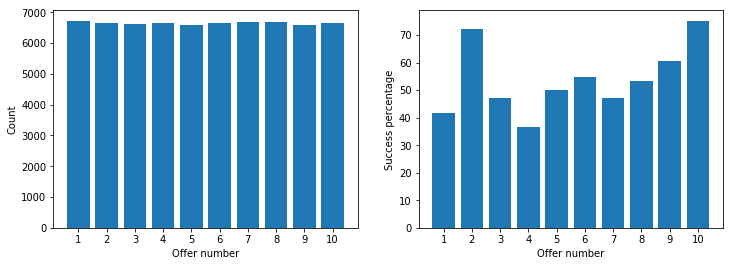

In [78]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)

# plot that illustrate how many customers were provided with a specific offer
ax[0].bar(offer_response_df.index + 1, offer_response_df['count'])
ax[0].set_xticks(np.arange(0,10) + 1)
ax[0].set_xlabel('Offer number')
ax[0].set_ylabel('Count')

# plot that illustrate 
ax[1].bar(offer_response_df.index + 1, offer_response_df['success_pourcentage'])
ax[1].set_xticks(np.arange(0,10) + 1)
ax[1].set_xlabel('Offer number')
ax[1].set_ylabel('Success percentage')

From the results shown above, we notice that the number of offers sent to customers is almost the same.  
For the percentage of success of an offer, we observe that the offer number 10 and 2 are the most successful with rates 75.20% and 72.28%, the lowest is offer number 4 with rate 36.76%.

## 2. Build models

### 2.1 Create train and test datasets

the data we use is usually split into training data and test data. The training set contains a known output and the model learns on this data in order to be generalized to other data later on. We have the test dataset in order to test our model's prediction on this subset.

In [79]:
# show the columns of the combined datset 
combined_data_df.columns

Index(['customer_id', 'offer_id', 'time', 'difficulty', 'duration', 'reward',
       'email', 'mobile', 'social', 'web', 'bogo', 'discount', 'informational',
       'gender', 'income', 'age_by_decade', 'became_member_year',
       'became_member_month', 'became_member_day', 'became_member_tenure',
       'income_by_range', 'F', 'M', 'O', 'age_10s', 'age_20s', 'age_30s',
       'age_40s', 'age_50s', 'age_60s', 'age_70s', 'age_80s', 'age_90s',
       'age_100s', '2013', '2014', '2015', '2016', '2017', '2018', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'income_30ths', 'income_40ths', 'income_50ths', 'income_60ths',
       'income_70ths', 'income_80ths', 'income_90ths', 'income_100ths',
       'income_110ths', 'income_120ths', 'total_amount', 'cust_response'],
      dtype='object')

In [80]:
# Drop features from combined_data which are not required for training the model
combined_data_df.drop(columns=['customer_id', 'offer_id', 'time', 'email','gender', 'income', 'age_by_decade','became_member_year',
'became_member_month', 'became_member_day','income_by_range'], inplace=True)


In [81]:
# combined_data culumns after dropping unuseful columns 
combined_data_df.columns

Index(['difficulty', 'duration', 'reward', 'mobile', 'social', 'web', 'bogo',
       'discount', 'informational', 'became_member_tenure', 'F', 'M', 'O',
       'age_10s', 'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s',
       'age_70s', 'age_80s', 'age_90s', 'age_100s', '2013', '2014', '2015',
       '2016', '2017', '2018', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'income_30ths', 'income_40ths', 'income_50ths',
       'income_60ths', 'income_70ths', 'income_80ths', 'income_90ths',
       'income_100ths', 'income_110ths', 'income_120ths', 'total_amount',
       'cust_response'],
      dtype='object')

In [82]:
combined_data_df.head()

,difficulty,duration,reward,mobile,social,web,bogo,discount,informational,became_member_tenure,...,income_50ths,income_60ths,income_70ths,income_80ths,income_90ths,income_100ths,income_110ths,income_120ths,total_amount,cust_response
0,5,168,5,1,0,1,1,0,0,1095,...,0,0,0,0,0,1,0,0,37.67,1
1,0,72,0,1,1,0,0,0,1,1095,...,0,0,0,0,0,1,0,0,49.39,1
2,10,168,10,1,1,0,1,0,0,1095,...,0,0,0,0,0,1,0,0,48.28,1
3,5,120,5,1,1,1,1,0,0,1095,...,0,0,0,0,0,1,0,0,48.28,1
4,10,168,2,1,0,1,0,1,0,743,...,0,0,1,0,0,0,0,0,0.00,0


In [83]:
# split data into features X and target y
# features : independece variables that act as the input of the model
X = combined_data_df.drop(columns=['cust_response'])
# target : the variable to predict 
y = combined_data_df['cust_response']

In [84]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 2.2 Scale features

In [85]:
# Prepare list of features to scale
features_to_scale = ['difficulty', 'duration', 'reward', 'became_member_tenure', 'total_amount']

In [86]:
def features_scale(df, feat=features_to_scale):
    
    
    """
    Scale list features in a given dataframe
    
    INPUT:
    - df (dataframe): dataframe having features to scale
    - feat (list): list of features in dataframe to scale
            
    OUTPUT:
    - scaled_df (dataframe): dataframe containing scaled features
    """
        
    # Prepare dataframe with features to scale
    df_feat_scale = df[feat]
        
    # Apply feature scaling to df
    scaler = MinMaxScaler()
    df_feat_scale = pd.DataFrame(scaler.fit_transform(df_feat_scale), columns = df_feat_scale.columns,index=df_feat_scale.index)
        
    # Drop orignal features from df and add scaled features 
    df = df.drop(columns=feat, axis=1)
    df_scaled = pd.concat([df, df_feat_scale], axis=1)
        
    return df_scaled

In [87]:
# Scale selected features in training set i.e. X_train
X_train_scaled = features_scale(X_train, feat=features_to_scale)
X_train_scaled.head()

,mobile,social,web,bogo,discount,informational,F,M,O,age_10s,...,income_80ths,income_90ths,income_100ths,income_110ths,income_120ths,difficulty,duration,reward,became_member_tenure,total_amount
58908,1,1,1,0,1,0,1,0,0,0,...,0,0,1,0,0,0.50,1.000000,0.2,0.164564,0.124780
19120,1,1,1,0,1,0,1,0,0,0,...,0,0,1,0,0,0.50,1.000000,0.2,0.587493,0.104793
28550,1,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0.25,0.571429,0.5,0.302798,0.052758
33970,1,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0.50,0.571429,1.0,0.160724,0.007836
50388,1,1,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0.50,0.285714,1.0,0.493143,0.034598


In [88]:
# Percenatge of distribution of the target class in training set
round((y_train.squeeze().value_counts()/y_train.squeeze().count())*100,2)

1    53.8
0    46.2
Name: cust_response, dtype: float64

From the results shown above, we can observe that our training dataset is nearly balanced, it has nearly equal number of customers whom responded to an offer (53.8%) and customers whom did not responded to an offer (46.2%). Since, our training dataset is nearly balanced, we do not have to deal with techniques to combat class imbalance.

In [89]:
# Distribution of the target class in test set
round((y_test.squeeze().value_counts()/y_test.squeeze().count())*100,2)

1    54.19
0    45.81
Name: cust_response, dtype: float64

From the results shown above, we can observe that our testing dataset is also nearly balanced.

### 2.3 train classifier 

##### Select the appropriate performance matrix

We found that our training data is nearly balanced in terms of distribution of target class, performance metrics like precision, recall, and f1_score are perfect measures for evaluating a model. F1-score metric is "the harmonic mean of the precision and recall metrics" and is better way of providing greater predictive power on the problem and how good the predictive model is making predictions. 

In [90]:
def fit_classifier(clf, param_grid, X=X_train_scaled.values, y=y_train.squeeze().values):

    """
    Fits a classifier to its training data using GridSearchCV and calculates f1_score
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train_scaled (DataFrame): training features
    - y_train (DataFrame): training label
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    
    # cv uses StratifiedKFold
    # scoring f1 available as parameter
    start = time.time()
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='f1', cv=5, verbose=0)
    print("Training {} :".format(clf.__class__.__name__))
    grid.fit(X, y)
    end = time.time()
    time_taken = round(end-start,2)

    print(clf.__class__.__name__)
    print("Time taken : {} secs".format(time_taken))
    print("Best f1_score : {}".format(round(grid.best_score_,4)))
    print("*"*40)
    
    return grid.best_score_, grid.best_estimator_, time_taken

In [91]:
# Initialize classification algorithms
lr = LogisticRegression(random_state=42) # LogisticRegression
rfc = RandomForestClassifier(random_state=42) # RandomForestClassifier
gbc = GradientBoostingClassifier(random_state=42) # GradientBoostingClassifier
abc = AdaBoostClassifier(random_state=42) # AdaBoostClassifier

In [92]:
# Find best classification algorithm
cl_names = []
cl_scores = []
cl_best_ests = []
cl_time_taken = []
cl_dict = {}

for classifier in [lr, rfc, abc, gbc]:
    best_score, best_est, time_taken = fit_classifier(classifier, {})
    cl_names.append(classifier.__class__.__name__)
    cl_scores.append(best_score)
    cl_best_ests.append(best_est)
    cl_time_taken.append(time_taken)

Training LogisticRegression :
LogisticRegression
Time taken : 4.13 secs
Best f1_score : 0.8416
****************************************
Training RandomForestClassifier :
RandomForestClassifier
Time taken : 3.78 secs
Best f1_score : 0.9196
****************************************
Training AdaBoostClassifier :
AdaBoostClassifier
Time taken : 14.92 secs
Best f1_score : 0.8957
****************************************
Training GradientBoostingClassifier :
GradientBoostingClassifier
Time taken : 49.22 secs
Best f1_score : 0.9205
****************************************


RandomForestClassifier and GradientBoostingClassifier has nearly equal f1_score(approx. 0.92) but RandomForestClassifier take very less time to train than the GradientBoostingClassifier. Therefore, best performing classifier algorithm among the above 4 classifiers is RandomForestClassifier.

In [93]:
# Create clf_df dataframe from clf_dict
cl_dict['best_f1_score'] = cl_scores
cl_dict['time_taken(s)'] = cl_time_taken
cl_dict['best_est'] = cl_best_ests
cl_df = pd.DataFrame(cl_dict, index=cl_names)
cl_df

,best_f1_score,time_taken(s),best_est
LogisticRegression,0.841585,4.13,"LogisticRegression(C=1.0, class_weight=None, d..."
RandomForestClassifier,0.919607,3.78,"(DecisionTreeClassifier(class_weight=None, cri..."
AdaBoostClassifier,0.895732,14.92,"(DecisionTreeClassifier(class_weight=None, cri..."
GradientBoostingClassifier,0.920536,49.22,([DecisionTreeRegressor(criterion='friedman_ms...


In [94]:
# display parametrs of RandomForestClassifier
cl_df.loc['RandomForestClassifier', 'best_est']

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [95]:
# Tuninig RandomForestClassifier classifier with the help of param grid in GridSearchCV
param_grid = {
               # Number of trees in random forest
              'n_estimators': [10, 50, 80, 100],
               # Maximum number of levels in tree
              'max_depth': [None],
               # Minimum number of samples required to split a node
              'min_samples_split': [2, 5, 10],
               # Minimum number of samples required at each leaf node
              'min_samples_leaf': [1, 2, 4]}

rfc = RandomForestClassifier(random_state=42)
rfc_best_score, rfc_best_est, _ = fit_classifier(rfc, param_grid)
rfc_best_est

Training RandomForestClassifier :
RandomForestClassifier
Time taken : 577.71 secs
Best f1_score : 0.9294
****************************************


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

We notive that after fine tuning the trained RandomForestClassifier, we get e better f1_score of 0.9294.

#### 2.4 Feature importance by RandomForestClassifier

In [96]:
# Prepare a dataframe with features and their importance by RandomForestClassifier
feature_imp = pd.DataFrame(rfc_best_est.feature_importances_,index=X_train_scaled.columns.tolist(),columns=['feat_imp']).reset_index()

feature_imp.rename(columns={'index': 'feature'}, inplace=True)
feature_imp['feat_imp_rate'] = np.round((feature_imp['feat_imp']/feature_imp['feat_imp'].sum())*100,2)
feature_imp = feature_imp.sort_values(by=['feat_imp_rate'], ascending=False).reset_index(drop=True)
feature_imp.drop(columns=['feat_imp'],inplace=True)
feature_imp

,feature,feat_imp_rate
0,total_amount,61.00
1,became_member_tenure,9.74
2,social,1.86
3,duration,1.49
4,difficulty,1.47
5,reward,1.41
6,2018,1.40
7,2016,0.99
8,income_30ths,0.84
9,age_50s,0.84


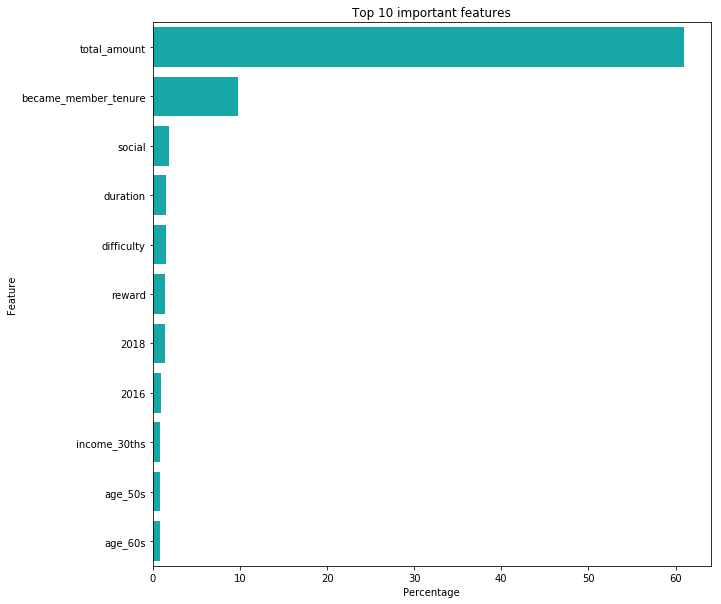

In [97]:
# Plot bar chart of features with their importance
fig, ax = plt.subplots(figsize=(10, 10),nrows=1,ncols=1)
sns.barplot(x=feature_imp.loc[0:10,'feat_imp_rate'], y=feature_imp.loc[0:10,'feature'], color='c', data=feature_imp)
plt.xlabel('Percentage')
plt.ylabel('Feature')
plt.title('Top 10 important features')
plt.show()

From the results shown above we notice that :

Top 10 features which influence whether the customer will respond to an offer or not after viewing the offer are: 
  
- total_amount spent by the customer is the most important feature which could herdly influence if the customer will complete an offer after viewing the offer.  
  
- 'became_member_tenure' is the second largest feature which represents, how long the customer has been the member of Starbucks reward program heavily influence if the customer will complete an offer after responding to it.
  
- 'social feature' which represents, if Starbucks sent the offer to customer via social media is likely to be responded more that other mode of communication.  
  
- 'difficulty' feature which represents, minimum amount to spent in order to complete the offer influence if the customer would response and complete the offer.  
  
- 'duration' feature which represents, how long the offer is valid influence the customer response and completion of the offer.  
  
- 'reward' feature which represents, how much amount as a reward, a customer is getting back influence if the customer would response and complete the offer.  
  
- '2018' and '2016' features, which represents if a customer became member of Starbucks reward program in years 2016 & 2018, had more chance of responding to an offer and completing it. 
  
- 'income_30ths' feature, which represents if customer's income is in 30000's or  which is the starting income group, then customer is likely to respond more to an offer and complete it.
  
- 'age_50s', 'age_60s' features which represents if the customer age is in 50's or 60's, then customer is likely to respond more to an offer and complete it. 
  

### 2.5 Predict test data

In [98]:
# Scale selected features in test data
X_test_scaled = features_scale(X_test, feat=features_to_scale)
X_test_scaled.head()

,mobile,social,web,bogo,discount,informational,F,M,O,age_10s,...,income_80ths,income_90ths,income_100ths,income_110ths,income_120ths,difficulty,duration,reward,became_member_tenure,total_amount
20034,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0.25,0.571429,0.5,0.503017,0.004838
55752,1,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0.50,0.571429,1.0,0.815688,0.016028
61495,1,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0.25,0.285714,0.5,0.399342,0.016362
34391,1,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0.25,0.285714,0.5,0.116292,0.000000
36619,1,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0.25,0.285714,0.5,0.149205,0.000669


In [99]:
# Classification of test data using best model trained on train data
predictions = rfc_best_est.predict(X_test_scaled)
predictions

array([0, 1, 1, ..., 0, 0, 1])

#### Confusion Matrix

In [100]:
# Calculate confusion matrix
confusion_matrix(y_test.squeeze().values, predictions)

array([[ 8115,  1024],
       [  456, 10356]])

In [101]:
# displaye tn, fp, fn, tp from confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test.squeeze().values, predictions).ravel()
print('true negatives: {}'.format(tn))
print('false postives: {}'.format(fp))
print('false negatives: {}'.format(fn))
print('true postives: {}'.format(tp))

true negatives: 8115
false postives: 1024
false negatives: 456
true postives: 10356


In [102]:
def plot_confusion_matrix(y_true, y_pred, classes,normalize=False,title=None,cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    INPUT:
    - y_true (np.array): array containing true labels
    - y_pred (np.array): array containing predicted labels
    - normalize (boolean): boolean value to determine whether to normalize the confusion matrix or not
    - title (str): title to use in confusion matrix plot
            
    OUTPUT:
    - ax (Axes object): Axes object to plot confusion matrix plot
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(conf_matrix)

    fig, ax = plt.subplots()
    im = ax.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(conf_matrix.shape[1]),
           yticks=np.arange(conf_matrix.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, format(conf_matrix[i, j], fmt),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[ 8115  1024]
 [  456 10356]]


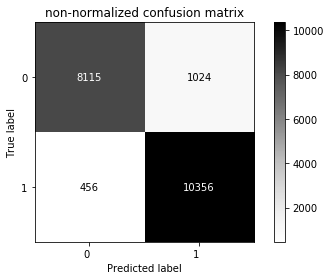

In [103]:
# Plot non-normalized confusion matrix
np.set_printoptions(precision=2)
class_names = np.array([0, 1])
plot_confusion_matrix(y_test.squeeze().values, predictions, classes=class_names,title='non-normalized confusion matrix')

Normalized confusion matrix
[[ 0.89  0.11]
 [ 0.04  0.96]]


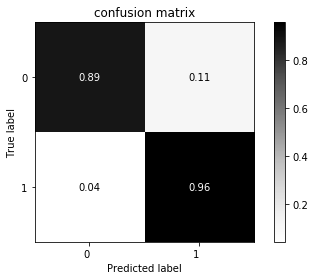

In [104]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test.squeeze().values, predictions, classes=class_names, normalize=True,title='confusion matrix')

the results shows that there are 4% pourcentge misclassifying customer acceptance for an offer, and 11% misclassifying customer refusal for an offer. As, False Negatives is less than False positives, our predictive model is doing perfect as it has very low chances of missing an individual who would respond. 


As Starbucks would not like to miss sending offers to individuals who would respond, this model is suitable for this case, since it wouldn't miss sending offers to individuals who can respond. Also, Starbucks would not mind sending offers to few individuals who would not respond,as they have covered up all the individuals who would respond. Therefore, our predictive model would work fine in this case.

## Conclusion

The problem that I chose to solve was to build a model that predicts whether a customer will respond to an offer. My strategy for solving this problem has mainly three steps. First, after preprocessing portfolio, profile and transaction datasets, I combined them to get a final clean data containing relevant features which can be used to train our model. Second, After splitting data to train and test datasets, we chose the best estimator "RandomForestClassifier" using GridSearch which is the best performing classifier algorithm among the above 4 classifiers tested (I compared F1-score and time taken). Third, I predited the test target using test data, and plot a confusion matrix to ensure the prformance of our model, we found that our predictive model is well suited for this case.

I enjoyed working on this project which allowed me to work on a real-world project. The most interesting aspect of this project is that combination between different datasets, and using predictive modeling techniques and analysis to provide better decisions and value to the business. The wrangling step was the longest and most challenging part. The toughest part of this entire analysis was finding logic and strategy to make combined dataset, and deciding on the problem statement.

## Improvements

1.Better predictions may have been deducted if there were more customer metrics. For this analysis, I feel we had limited information about customer available to us just age, gender, and income. To find optimal customer demographics, it would be nice to have a few more features of a customer. These additional features may aid in providing better classification model results data in order to have more better model.
  
2.Additionaly initially it seemed like we had a lot of data to work, but once NaN values and duplicate columns were dropped and the data were combined into one single dataset, it felt as though the models might have benefited from more data. With more data, the classification models may have been able to produce better F1-score results.
   
3.Also, we can improve this project by taking up another problem statement,we can make a model that predicts which demographic groups will make purchases even if they don't receive an offer.
